In [ ]:
# Execute this cell to install dependencies
%pip install sf-hamilton[visualization]

# Hello world tutorial [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/dagworks-inc/hamilton/blob/main/examples/dask/hello_world/notebook.ipynb) [![GitHub badge](https://img.shields.io/badge/github-view_source-2b3137?logo=github)](https://github.com/dagworks-inc/hamilton/blob/main/examples/dask/hello_world/notebook.ipynb)


Uncomment and run the cell below if you are in a Google Colab environment. It will:
1. Mount google drive. You will be asked to authenticate and give permissions.
2. Change directory to google drive.
3. Make a directory "hamilton-tutorials"
4. Change directory to it.
5. Clone this repository to your google drive
6. Move your current directory to the hello_world example
7. Install requirements.

This means that any modifications will be saved, and you won't lose them if you close your browser.

In [1]:
## 1. Mount google drive
# from google.colab import drive
# drive.mount('/content/drive')
## 2. Change directory to google drive.
# %cd /content/drive/MyDrive
## 3. Make a directory "hamilton-tutorials"
# !mkdir hamilton-tutorials
## 4. Change directory to it.
# %cd hamilton-tutorials
## 5. Clone this repository to your google drive
# !git clone https://github.com/DAGWorks-Inc/hamilton/
## 6. Move your current directory to the hello_world example
# %cd hamilton/examples/hello_world
## 7. Install requirements.
# %pip install -r requirements.txt
# clear_output()  # optionally clear outputs
# To check your current working directory you can type `!pwd` in a cell and run it.

In [2]:
# Cell 2 - import modules to create part of the DAG from
# We use the autoreload extension that comes with ipython to automatically reload modules when
# the code in them changes.

# import the jupyter extension
%load_ext autoreload
# set it to only reload the modules imported
%autoreload 1

In [3]:
# Import modules

import pandas as pd
from dask import dataframe
from dask.distributed import (
    Client,
    LocalCluster,
)

from hamilton import driver
from hamilton.plugins import h_dask

In [4]:
%%writefile data_loaders.py

import pandas as pd
from dask import dataframe

# We'll place the data loaders into a new module

def spend(spend_location: str, spend_partitions: int) -> dataframe.Series:
    """Dummy function showing how to wire through loading data.

    :param spend_location:
    :param spend_partitions: number of partitions to segment the data into
    :return:
    """
    return dataframe.from_pandas(
        pd.Series([10, 10, 20, 40, 40, 50]), name="spend", npartitions=spend_partitions
    )


def signups(signups_location: str, signups_partitions: int) -> dataframe.Series:
    """Dummy function showing how to wire through loading data.

    :param signups_location:
    :param signups_partitions: number of partitions to segment the data into
    :return:
    """
    return dataframe.from_pandas(
        pd.Series([1, 10, 50, 100, 200, 400]), name="signups", npartitions=signups_partitions
    )

Overwriting data_loaders.py


In [5]:
%%writefile spend_calculations.py

# We'll place the spend calculations into a new module

import pandas as pd

def avg_3wk_spend(spend: pd.Series) -> pd.Series:
    """Rolling 3 week average spend."""
    return spend.rolling(3).mean()


def spend_per_signup(spend: pd.Series, signups: pd.Series) -> pd.Series:
    """The cost per signup in relation to spend."""
    return spend / signups


def spend_mean(spend: pd.Series) -> float:
    """Shows function creating a scalar. In this case it computes the mean of the entire column."""
    return spend.mean()


def spend_zero_mean(spend: pd.Series, spend_mean: float) -> pd.Series:
    """Shows function that takes a scalar. In this case to zero mean spend."""
    return spend - spend_mean


def spend_std_dev(spend: pd.Series) -> float:
    """Function that computes the standard deviation of the spend column."""
    return spend.std()


def spend_zero_mean_unit_variance(spend_zero_mean: pd.Series, spend_std_dev: float) -> pd.Series:
    """Function showing one way to make spend have zero mean and unit variance."""
    return spend_zero_mean / spend_std_dev

Overwriting spend_calculations.py


In [6]:
%aimport data_loaders, spend_calculations

# Set up the local Dask cluster, adapter, and driver.

cluster = LocalCluster()
client  = Client(cluster)

print(client.cluster)

adapter = h_dask.DaskGraphAdapter(
    client,
    h_dask.DaskDataFrameResult(),
    visualize_kwargs={"filename": "run_dask.png", "format": "png"},
    use_delayed=False,
    compute_at_end=False,
)

config = {
    "spend_location": "some file path",
    "spend_partitions": 2,
    "signups_location": "some file path",
    "signups_partitions": 2,
    "foobar": "some_other_data",
}

dr = driver.Driver(config, spend_calculations, data_loaders, adapter=adapter)

Note: Hamilton collects completely anonymous data about usage. This will help us improve Hamilton over time. See https://github.com/dagworks-inc/hamilton#usage-analytics--data-privacy for details.


LocalCluster(94f8c394, 'tcp://127.0.0.1:50070', workers=4, threads=8, memory=16.00 GiB)


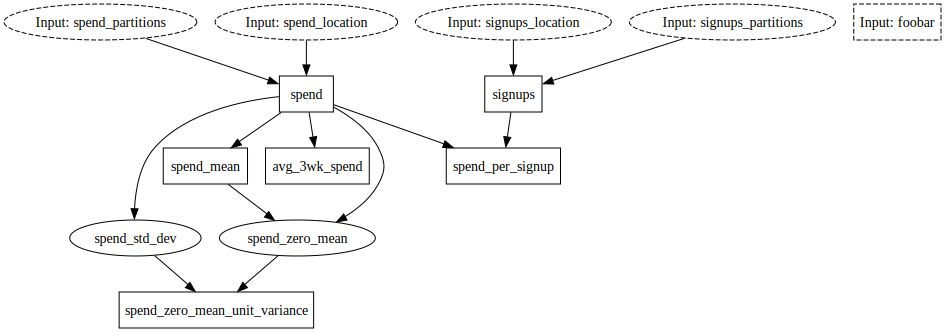

In [7]:
# Execute the driver.

output_columns = [
    "spend",
    "signups",
    "avg_3wk_spend",
    "spend_per_signup",
    "spend_mean",
    "spend_zero_mean_unit_variance",
    "foobar",
]

dask_df = dr.execute(output_columns)  # it's dask dataframe -- it hasn't been evaluated yet.
df = dask_df.compute()

# To visualize do `pip install "sf-hamilton[visualization]"` if you want these to work
dr.visualize_execution(output_columns)

In [9]:
print(df.to_string())
client.shutdown()

   spend  signups  avg_3wk_spend  spend_per_signup  spend_mean  spend_zero_mean_unit_variance           foobar
0     10        1            NaN            10.000   28.333333                      -1.064405  some_other_data
1     10       10            NaN             1.000   28.333333                      -1.064405  some_other_data
2     20       50      13.333333             0.400   28.333333                      -0.483821  some_other_data
3     40      100      23.333333             0.400   28.333333                       0.677349  some_other_data
4     40      200      33.333333             0.200   28.333333                       0.677349  some_other_data
5     50      400      43.333333             0.125   28.333333                       1.257934  some_other_data
